<a href="https://colab.research.google.com/github/devangi2000/Deep-Learning/blob/master/keras_ocr_fine_tuning_detector_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is an interactive version of [this example](https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_detector.html).

This example shows how to fine-tune the recognizer using an existing dataset. In this case,
we will use the text segmentation dataset from ICDAR 2013, available from
https://rrc.cvc.uab.es/?ch=1&com=downloads.

First, we download our dataset.

In [1]:
!pip install keras_ocr

     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 9.5MB 7.5MB/s 
     |████████████████████████████████| 829kB 54.5MB/s 
     |████████████████████████████████| 133kB 58.0MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.5-cp36-none-any.whl size=42813 sha256=38117d42054a8d15f24f5344a869e47054e3d679d0d0bafafcd1e6ae378f7e93
  Stored in directory: /root/.cache/pip/wheels/26/fd/d6/905d0757789c5526744770d788286a85c925580d741ebf7b7e
Successfully built keras-ocr


In [2]:
data_dir = '.'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf

import keras_ocr

In [3]:
dataset = keras_ocr.datasets.get_icdar_2013_detector_dataset(
    cache_dir='.',
    skip_illegible=False
)

Looking for ./icdar2013/Challenge2_Training_Task12_Images.zip
Looking for ./icdar2013/Challenge2_Training_Task2_GT.zip


In [4]:
train, validation = sklearn.model_selection.train_test_split(
    dataset, train_size=0.8, random_state=42
)
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(
      scale=(1.0, 1.2),
      rotate=(-5, 5)
    ),
    imgaug.augmenters.GaussianBlur(sigma=(0, 0.5)),
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2)
])
generator_kwargs = {'width': 640, 'height': 640}
training_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=train,
    augmenter=augmenter,
    **generator_kwargs
)
validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=validation,
    **generator_kwargs
)

We can visualize what the samples look like pretty easily.

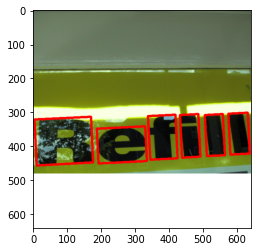

In [5]:
image, lines, confidence = next(training_image_generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)

Now we can build the detector and train it.

In [6]:
detector = keras_ocr.detection.Detector()

batch_size = 1
training_generator, validation_generator = [
    detector.get_batch_generator(
        image_generator=image_generator, batch_size=batch_size
    ) for image_generator in
    [training_image_generator, validation_image_generator]
]
detector.model.fit_generator(
    generator=training_generator,
    steps_per_epoch=math.ceil(len(train) / batch_size),
    epochs=1000,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(os.path.join(data_dir, 'detector_icdar2013.csv')),
        tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(data_dir, 'detector_icdar2013.h5'))
    ],
    validation_data=validation_generator,
    validation_steps=math.ceil(len(validation) / batch_size)
)

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/1000
183/183 [==============================] - 84s 458ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 2/1000
183/183 [==============================] - 83s 453ms/step - loss: 0.0117 - val_loss: 0.0161
Epoch 3/1000
183/183 [==============================] - 82s 450ms/step - loss: 0.0084 - val_loss: 0.0159
Epoch 4/1000
183/183 [==============================] - 83s 451ms/step - loss: 0.0087 - val_loss: 0.0104
Epoch 5/1000
183/183 [==============================] - 83s 454ms/step - loss: 0.0072 - val_loss: 0.0122
Epoch 6/1000
183/183 [==============================] - 85s 467ms/step - loss: 0.0043 - val_loss: 0.0084
Epoch 7/1000
183/183 [==============================] - 86s 472ms/step - loss: 0.0040 - val_loss: 0.0094
Epoch 8/1000
183/183 [==============================] - 87s 476ms/step - loss: 0.0059 - val_loss: 0.0153
Epoch 9/1000
183/183 [================

Weights can be loaded into the model attribute of the detector. This is how you can reuse the weights later.

In [7]:
detector.model.load_weights(os.path.join(data_dir, 'detector_icdar2013.h5'))

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


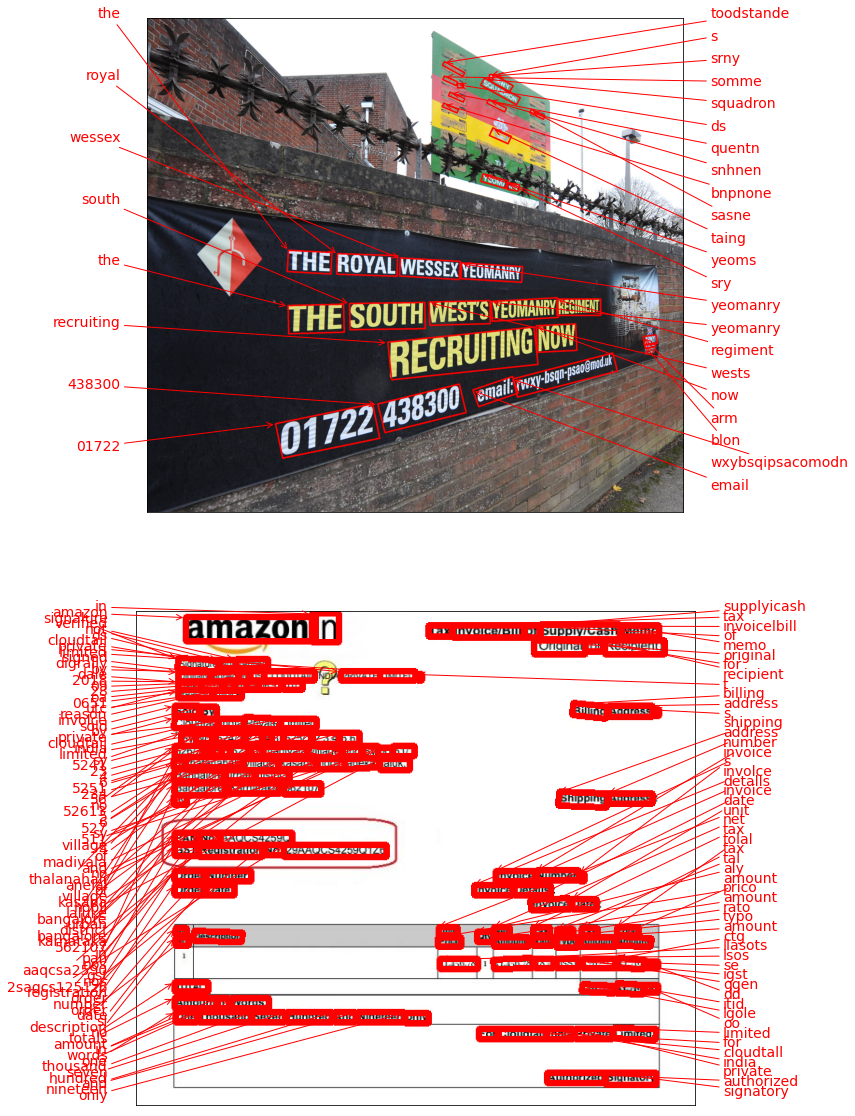

In [12]:
import matplotlib.pyplot as plt

import keras_ocr

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

# Get a set of three example images
images = [
    keras_ocr.tools.read(url) for url in [
        'https://upload.wikimedia.org/wikipedia/commons/b/bd/Army_Reserves_Recruitment_Banner_MOD_45156284.jpg',
        'https://taxguru.in/wp-content/uploads/2018/10/amzinv1-e1539229186364.jpg'
    ]
]

# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
prediction_groups = pipeline.recognize(images)

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)